#Leotta_2021_get_X_y_sub.ipynb

This version is depricated - the functionality here has been moved to Leotta_20201_load_dataset.ipynb.

Loads the dataset from a local zip file and converts the data into numpy arrays of X (data), y(labels), and sub (subject numbers)
>X = (samples, time steps per sample, accel_x/y/z/total_accel)  
>y = (samples, {0,1,...17}) #activity classification  
>s = subject number  

This is an intermediate representation that can be used to build the train/validate/test arrays.

Some functions are defined, but this is mostly meant to be run in interactive
mode with the files saved at the end.

The dataset citation and link to the paper and download are available on this site https://sepl.dibris.unige.it/2020-DailyActivityDataset.php

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

[Lee B. Hinkle](https://userweb.cs.txstate.edu/~lbh31/), Texas State University, [IMICS Lab](https://imics.wp.txstate.edu/)  
TODO:
* This is still work-in-progress
* Figure out how to replace int labels with strings - seems like it should be easy, but apparently not.
* Reshape from big df to numpy arrays crashes unless run on colab high RAM runtime.   Maybe reduce y and sub types to int8?
* Make timesteps and stepsize passed parameters from get_X_y_sub


In [1]:
import os
import shutil #https://docs.python.org/3/library/shutil.html
from shutil import unpack_archive # to unzip
import urllib.request # to get files from web w/o !wget

#from shutil import make_archive # to create zip for storage
import requests #for downloading zip file
from scipy import io #for loadmat, matlab conversion
import time
import pandas as pd
import numpy as np
from numpy import savetxt
import matplotlib.pyplot as plt # for plotting - pandas uses matplotlib
from tabulate import tabulate # for verbose tables
from tensorflow.keras.utils import to_categorical # for one-hot encoding
import gc #trying to resolve crash on reshape method

In [2]:
def get_web_file(fname, url):
    """checks for local file, if none downloads from URL.    
    :return: nothing"""
    if (os.path.exists(fname)):
        print ("Local",fname, "found, skipping download")
    else:
        print("Downloading",fname, "from", url)
        urllib.request.urlretrieve(url, filename=fname)

# Load shared transform (xforms) functions and utils from IMICS Public Repo



In [3]:
try:
    import load_data_transforms as xforms
except:
    get_web_file(fname = 'load_data_transforms.py', url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/load_data_transforms.py')
    import load_data_transforms as xforms

try:
    import load_data_utils as utils  
except:
    get_web_file(fname = 'load_data_utils.py', url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/load_data_utils.py')
    import load_data_utils as utils

# Global and Dataset Parameters

In [4]:
# environment and execution parameters
my_dir = '.' # replace with absolute path if desired
dataset_dir = os.path.join(my_dir,'dataset') # temp dir for processing

interactive = True # for exploring data and functions interactively
verbose = True

log_info = "" # a global to append dataset processing info

# dataset parameters
all_channel_list = ['accel_x', 'accel_y', 'accel_z','accel_ttl','bvp','eda','p_temp']
# frequency = 32 - unlike some of the other loaders this is hardcoded due to
# the unique sample freqencies that differ between the individual e4 sensors
xforms.time_steps = 96 # three seconds at 32Hz
xforms.stride = 32 # one second step for each sliding window
# The label_map_<dataset> contains a mapping from strings to ints for all
# possible labels in the entire dataset.   This allows for predictable conversion
# regardless of the slices.  I'm using 99 for 'unknown' which will be dropped
# to avoid the confusion of shifing by 1 place, zero indexed etc.
# Also this label map dict is setup to handle multi-labels but TWRristAR 
# has only a single activity label.
subj_alloc_dict = dict (train_subj = [1,2], valid_subj = [], test_subj = [3])
label_map_twristar = {"label":     {"Downstairs": 0, "Jogging": 1, "Sitting": 2,
                                "Standing": 3, "Upstairs": 4, "Walking": 5,
                                "Undefined": 99}}
scripted = True # TWristAR has two categories of data - scripted activities
                # and unscripted, set to false to get the unscripted data.
                # See example in bottom of this notebook.

In [ ]:
interactive = False # runs when saved as .py, skip cell if developing/debugging

In [5]:
# Please go to https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/G23QTS
# to read through the terms and also find the proper citations if you use this dataset.
# This is also where you can download directly if the link below fails.

# https://drive.google.com/file/d/1P5PIYeYvbfL4kQj-P2sm-JquUIddAxec/view?usp=sharing
!gdown "1P5PIYeYvbfL4kQj-P2sm-JquUIddAxec&confirm=t" # ADL_Leotta_2021.zip
#utils.unzip_into_dir('PSG_18ch_IR1_1_of_5.zip','PSG_IR1')

Downloading...
From: https://drive.google.com/uc?id=1P5PIYeYvbfL4kQj-P2sm-JquUIddAxec&confirm=t
To: /content/ADL_Leotta_2021.zip
100% 258M/258M [00:04<00:00, 57.7MB/s]


In [6]:
def unzip_leotta():
    """check for local copy, if none unzips the dataset structure in working_dir"""
    if (os.path.isdir(dataset_dir)):
        print("Using existing archive in colab")
        return
    else:
        print("Unzipping Leotta 2021 dataset into", dataset_dir)
        zip_ffname = os.path.join(my_dir, 'ADL_Leotta_2021.zip')
        if (os.path.exists(zip_ffname)):
            print("Using source file", zip_ffname)
            shutil.unpack_archive(zip_ffname,dataset_dir,'zip')
        else:
            print("ERROR: ", zip_ffname, " not found")
            print("Go to https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/G23QTS")
            print("Click access dataset on right, accept terms, download zip and place in current directory")
            print("with filename ADL_Leotta_2021.zip, should be a 246.2MB zip file")
            return
if interactive:
    unzip_leotta()

Unzipping Leotta 2021 dataset into ./dataset
Using source file ./ADL_Leotta_2021.zip


In [11]:
def df_from_csv (
    sub_num, # 1 - 8
    sensor_loc): # ankle, hip, wrist
    #working_dir = '/content/dataset'): # location of unzipped files in colab 
    """reads csv, returns df with accel x/y/z/ttl, label, sub_num"""
    fnameX = sensor_loc + '_X_0' + str(sub_num) +  '.csv'
    fnamey = sensor_loc + '_Y_0' + str(sub_num) +  '.csv'
    ffnameX = os.path.join(dataset_dir, sensor_loc, fnameX)
    ffnamey = os.path.join(dataset_dir, sensor_loc, fnamey)
    print ('Processing: ', ffnameX, ffnamey)
    df = pd.read_csv(ffnameX)
    if (sensor_loc == 'wrist'): # Centrepoint device has different header name
        df.rename(columns={'Timestamp UTC': 'Timestamp'}, inplace=True)
    # the imported Timestamp is an object - need to convert to DateTime
    # in order to set the index to DateTime format.  Enables resampling etc.
    # Leaving these here - helpful to debug if leveraging this code!
        #print("*** Start ***")
        #print(type(df.index))
        #print(df.info(verbose=True))  
    df['Timestamp'] = pd.to_datetime(df['Timestamp']) 
    df.set_index('Timestamp', drop = True, inplace = True)
    if (sensor_loc != 'wrist'): # Centrepoint doesn't have non-accel columnns
        df = df.drop(['Temperature','Gyroscope X','Gyroscope Y','Gyroscope Z',
                      'Magnetometer X','Magnetometer Y','Magnetometer Z'], axis=1)
    df_sqd = df.pow(2)[['Accelerometer X','Accelerometer Y','Accelerometer Z']] #square each accel
    df_sum = df_sqd.sum(axis=1) #add sum of squares, new 1 col df
    df.loc[:,'accel_ttl'] = df_sum.pow(0.5)-1  # sqrt and remove 1g due to gravity
    del df_sqd, df_sum
    df.columns = [sensor_loc + '_accel_x', sensor_loc + '_accel_y', sensor_loc + '_accel_z', sensor_loc + '_accel_ttl']
    # add activity numbers - number of rows are the same in this dataset
    # Why doesn't this work? df['label'] = pd.read_csv(ffnamey, dtype='Int64')
    dfy = pd.read_csv(ffnamey)
    df['label']=dfy['label'].to_numpy() # this works, above doesn't?
    df['label'] = df['label'].astype(int) # change from float to int
    del dfy
    # add column with subject number
    df['sub'] = sub_num
    return df
if interactive:
    snum = 1
    df_ankle = df_from_csv(sub_num = snum, sensor_loc = 'ankle')
    df_hip = df_from_csv(sub_num = snum, sensor_loc = 'hip')
    df_wrist = df_from_csv(sub_num = snum, sensor_loc = 'wrist')
    display(df_ankle.info())
    display(df_hip.info())
    display(df_wrist.info())
    display(df_ankle.head())
    display(df_hip.head())
    display(df_wrist.head())


Processing:  ./dataset/ankle/ankle_X_01.csv ./dataset/ankle/ankle_Y_01.csv
Processing:  ./dataset/hip/hip_X_01.csv ./dataset/hip/hip_Y_01.csv
Processing:  ./dataset/wrist/wrist_X_01.csv ./dataset/wrist/wrist_Y_01.csv
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 305000 entries, 2020-07-30 11:21:00 to 2020-07-30 12:11:49.990000
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   ankle_accel_x    305000 non-null  float64
 1   ankle_accel_y    305000 non-null  float64
 2   ankle_accel_z    305000 non-null  float64
 3   ankle_accel_ttl  305000 non-null  float64
 4   label            305000 non-null  int64  
 5   sub              305000 non-null  int64  
dtypes: float64(4), int64(2)
memory usage: 16.3 MB


None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 305000 entries, 2020-07-30 11:21:00 to 2020-07-30 12:11:49.990000
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   hip_accel_x    305000 non-null  float64
 1   hip_accel_y    305000 non-null  float64
 2   hip_accel_z    305000 non-null  float64
 3   hip_accel_ttl  305000 non-null  float64
 4   label          305000 non-null  int64  
 5   sub            305000 non-null  int64  
dtypes: float64(4), int64(2)
memory usage: 16.3 MB


None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 780800 entries, 2020-07-30 11:21:00 to 2020-07-30 12:11:49.996000
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   wrist_accel_x    780800 non-null  float64
 1   wrist_accel_y    780800 non-null  float64
 2   wrist_accel_z    780800 non-null  float64
 3   wrist_accel_ttl  780800 non-null  float64
 4   label            780800 non-null  int64  
 5   sub              780800 non-null  int64  
dtypes: float64(4), int64(2)
memory usage: 41.7 MB


None

,ankle_accel_x,ankle_accel_y,ankle_accel_z,ankle_accel_ttl,label,sub
Timestamp,,,,,,
2020-07-30 11:21:00.000,-0.035156,-1.027832,0.029785,0.028864,0,1
2020-07-30 11:21:00.010,-0.022949,-1.023926,0.033203,0.024721,0,1
2020-07-30 11:21:00.020,-0.010254,-1.028320,0.038574,0.029094,0,1
2020-07-30 11:21:00.030,-0.000977,-1.026855,0.048340,0.027993,0,1
2020-07-30 11:21:00.040,0.003906,-1.031250,0.038574,0.031979,0,1


,hip_accel_x,hip_accel_y,hip_accel_z,hip_accel_ttl,label,sub
Timestamp,,,,,,
2020-07-30 11:21:00.000,-0.583984,-0.764160,0.374023,0.031926,0,1
2020-07-30 11:21:00.010,-0.579102,-0.756348,0.374512,0.023563,0,1
2020-07-30 11:21:00.020,-0.578613,-0.758301,0.367676,0.022252,0,1
2020-07-30 11:21:00.030,-0.578125,-0.756836,0.374023,0.023192,0,1
2020-07-30 11:21:00.040,-0.575195,-0.755371,0.372559,0.019919,0,1


,wrist_accel_x,wrist_accel_y,wrist_accel_z,wrist_accel_ttl,label,sub
Timestamp,,,,,,
2020-07-30 11:21:00.000,0.488770,0.034131,0.932903,0.053740,0,1
2020-07-30 11:21:00.003,0.484381,0.029987,0.932913,0.051595,0,1
2020-07-30 11:21:00.007,0.454181,0.025308,0.937344,0.041890,0,1
2020-07-30 11:21:00.011,0.475415,0.013587,0.937303,0.051066,0,1
2020-07-30 11:21:00.015,0.484052,0.013772,0.919827,0.039508,0,1


In [15]:
def to_fixed_timedelta(df_in, new_time_step='50ms'):
    """resamples DateTime indexed dataframe to new_time_step.  Will
    return NaN per resample method (happens on irregular samples). 'label' and
    'sub' columns will resample to floats and be typed back to ints"""
    orig_rows = len(df_in.index)
    df_out = df_in.resample(new_time_step).mean()
    df_out = df_out.interpolate() #linear interpolation for nan
    df_out['label'] = df_out['label'].astype(int) # change from float to int
    df_out['sub'] = df_out['sub'].astype(int) # change from float to int
    if verbose:
        print("Resampled at ",new_time_step,": Original/New # rows = ",orig_rows,len(df_out.index))
    return df_out
if interactive:
    df_temp = to_fixed_timedelta(df_wrist,new_time_step='10ms')
    df_temp.info()
# method copied from MobiAct_ADL_get_X_y_sub.ipynb, it is named this way
# because it can also be used to "correct" sample jitter in smartphone data

Resampled at  10ms : Original/New # rows =  780800 305000
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 305000 entries, 2020-07-30 11:21:00 to 2020-07-30 12:11:49.990000
Freq: 10L
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   wrist_accel_x    305000 non-null  float64
 1   wrist_accel_y    305000 non-null  float64
 2   wrist_accel_z    305000 non-null  float64
 3   wrist_accel_ttl  305000 non-null  float64
 4   label            305000 non-null  int64  
 5   sub              305000 non-null  int64  
dtypes: float64(4), int64(2)
memory usage: 16.3 MB


In [16]:
def df_from_one_sub (sub_num): # 1 - 8
    """reads 3 csv files for a single subject, combines an returns a single dataframe"""
    my_sub_num = sub_num # not sure necessary but easier to follow...
    df_ankle = df_from_csv(sub_num = my_sub_num, sensor_loc = 'ankle')
    df_hip = df_from_csv(sub_num = my_sub_num, sensor_loc = 'hip')
    #wrist is a bit more complicated since the sample rate is different
    df_wrist = df_from_csv(sub_num = my_sub_num, sensor_loc = 'wrist')
    df_wrist = to_fixed_timedelta(df_wrist,new_time_step='10ms')

    if ((df_ankle['label'].equals(df_hip['label']))
            and (df_ankle['sub'].equals(df_hip['sub']))
            and (df_ankle['label'].equals(df_wrist['label']))
            and (df_ankle['sub'].equals(df_wrist['sub']))) :
        print('confirmed label and sub match - dropping from ankle and hip')
        df_ankle.drop(['label','sub'], axis=1, inplace=True)
        df_hip.drop(['label','sub'], axis=1, inplace=True)
    else:
        print('Error:  label and sub do not match, cannot combine dataframes')
        print('label match = ',df_ankle['label'].equals(df_hip['label']))
        print('sub match = ',df_ankle['sub'].equals(df_hip['sub']))
    df_temp = df_ankle.join(df_hip)
    df_final = df_temp.join(df_wrist)
    del df_temp
    return df_final
if interactive:
    df_temp = df_from_one_sub (sub_num = 8)
    print(type(df_temp.index)) # should be DateTimeIndex
    print(df_temp.info(verbose=True))
    display(df_temp.head()) 

Processing:  ./dataset/ankle/ankle_X_08.csv ./dataset/ankle/ankle_Y_08.csv
Processing:  ./dataset/hip/hip_X_08.csv ./dataset/hip/hip_Y_08.csv
Processing:  ./dataset/wrist/wrist_X_08.csv ./dataset/wrist/wrist_Y_08.csv
Resampled at  10ms : Original/New # rows =  712704 278400
confirmed label and sub match - dropping from ankle and hip
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 278400 entries, 2020-07-31 16:18:00 to 2020-07-31 17:04:23.990000
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   ankle_accel_x    278400 non-null  float64
 1   ankle_accel_y    278400 non-null  float64
 2   ankle_accel_z    278400 non-null  float64
 3   ankle_accel_ttl  278400 non-null  float64
 4   hip_accel_x      278400 non-null  float64
 5   hip_accel_y      278400 non-null  float64
 6   hip_accel_z      278400 non-null  float64
 7   hip_accel_ttl    278400 non-nul

,ankle_accel_x,ankle_accel_y,ankle_accel_z,ankle_accel_ttl,hip_accel_x,hip_accel_y,hip_accel_z,hip_accel_ttl,wrist_accel_x,wrist_accel_y,wrist_accel_z,wrist_accel_ttl,label,sub
Timestamp,,,,,,,,,,,,,,
2020-07-31 16:18:00.000,0.591309,-0.828125,-0.100098,0.022476,-0.667969,-0.733398,0.255371,0.024339,0.168608,-0.184633,1.009314,0.039832,1,8
2020-07-31 16:18:00.010,0.594238,-0.828125,-0.104004,0.024562,-0.665527,-0.731445,0.271484,0.025496,0.179010,-0.168203,1.003467,0.033196,1,8
2020-07-31 16:18:00.020,0.594238,-0.828125,-0.100098,0.024173,-0.655273,-0.724121,0.280762,0.016150,0.198355,-0.168477,0.999061,0.032401,1,8
2020-07-31 16:18:00.030,0.591797,-0.829102,-0.095215,0.023083,-0.650879,-0.715332,0.289551,0.009546,0.203663,-0.155531,0.994681,0.027170,1,8
2020-07-31 16:18:00.040,0.584961,-0.825195,-0.091797,0.015654,-0.647949,-0.710449,0.296387,0.006191,0.196383,-0.160411,0.999062,0.030793,1,8


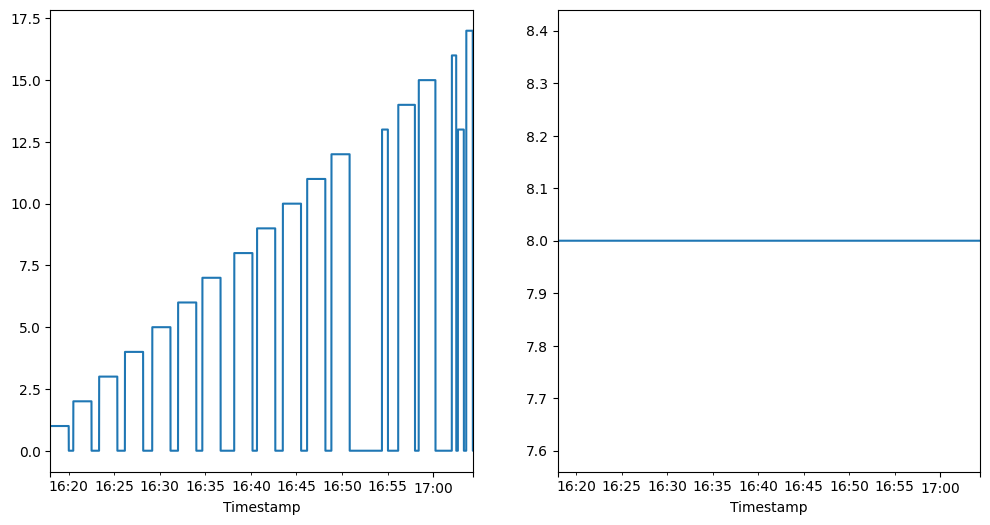

In [17]:
if interactive:
    #df_temp = my_df[my_df['label'] != 0] # drop 'other' labeled activities
    fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(12,6))
    df_temp['label'].plot(ax = axes[0], subplots=True) 
    df_temp['sub'].plot(ax = axes[1], subplots=True)
    plt.show()

In [18]:
if interactive:
    print('Act. # instances (rows)')
    print(df_temp['label'].value_counts()) # shows the number of each activity

Act. # instances (rows)
0     97400
1     12000
7     12000
12    12000
11    12000
10    12000
8     12000
9     12000
6     12000
5     12000
4     12000
3     12000
2     12000
14    11000
15    11000
13     7800
17     4300
16     2900
Name: label, dtype: int64


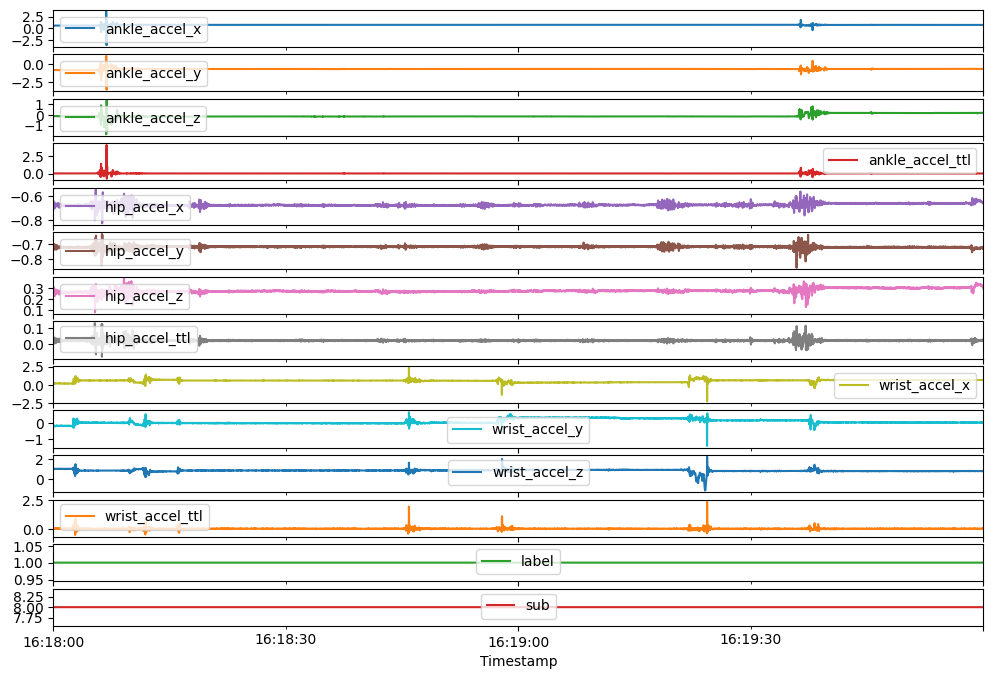

In [19]:
if interactive:
    # shows stacked acceleration diagrams for given label
    df_temp[df_temp['label'] == 1].plot(figsize=(12, 8),subplots = True)

# Dataframe pieces in place, next method takes dataframe and parses to numpy arrays
In order to limit memory requirements it is done by subject rather than creating one big dataframe as in other datasets

In [20]:
def split_df_to_timeslice_nparrays(df, features, time_steps, step):
    """slice the df into segments of time_steps length and return X, y, sub
    ndarrays.  if step = time_steps there is no overlap. Updated from original
    in e4_get_X_y_sub to accept list of features."""
    N_FEATURES = len(features)
    segments = []
    labels = []
    subject = []
    for i in range(0, len(df) - time_steps, step):
        #df_segX = df[['accel_x', 'accel_y', 'accel_z','accel_ttl']].iloc[i: i + time_steps]
        df_segX = df[features].iloc[i: i + time_steps]
        df_lbl = df['label'].iloc[i: i + time_steps]
        df_sub = df['sub'].iloc[i: i + time_steps]
        # Save only if labels are the same for the entire segment and valid
        if (df_lbl.value_counts().iloc[0] != time_steps):
            #print('Segment starting at',i,'contains multiple labels.  Discarding.')
            continue

        if 0 in df_lbl.values :
            #print('Segment starting at',i,'contains Undefined labels.  Discarding')
            continue
        # Save only if sub is the same for the entire segment and valid
        if (df_sub.value_counts().iloc[0] != time_steps):
            #print('Segment starting at',i,'contains multiple subjects.  Discarding.')
            continue
        segments.append(df_segX.to_numpy())
        labels.append(df['label'].iloc[i])
        subject.append(df['sub'].iloc[i])
        #this still requires high memory instance on colab.
        #del [[df_segX,df_lbl,df_sub]]
        del df_segX
        del df_lbl
        del df_sub
        gc.collect

    # Bring the segments into a better shape, convert to nparrays
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)
    subject = np.asarray(subject)
    # both labels and sub are row arrays, change to single column arrays
    labels = labels[np.newaxis].T
    subject = subject[np.newaxis].T
    # check for nan - issue with resampled data
    bad_data_locations = np.argwhere(np.isnan(reshaped_segments))
    np.unique(bad_data_locations[:,0]) #[:,0] accesses just 1st column
    if (bad_data_locations.size==0):
        print("No NaN entries found")
    else:
        print("Warning: Output arrays contain NaN entries")
        print("execute print(X[99]) # to view single sample")
    return reshaped_segments, labels, subject

In [26]:
def get_X_y_sub(
    time_steps = 0, #TODO - the timesteps do not propagate, set to 300 & 300
    step = 0 #if equal to time_steps there will be no overlap of sliding window
    ):
    """processes dataset zip file to extract csv file and convert into X (data),
     y (labels), and sub (subject number) ndarrays.
     Returns X, y, sub, xys_info (a text file)
    """
    unzip_leotta()
    xys_info = 'not setup for Leotta dataset'
    for i in range(1,9):
        print('Processing subject number', i)
        df_temp = df_from_one_sub (sub_num = i)
        feature_list = list(df_temp.columns)
        feature_list.remove('label')
        feature_list.remove('sub')
        print("Using",len(feature_list),'features',feature_list)
        my_X, my_y, my_sub = split_df_to_timeslice_nparrays(df_temp, feature_list, 300, 300)
        if i==1:
            X = my_X
            y = my_y
            sub = my_sub
        else:
            X = np.vstack([X, my_X])
            y = np.vstack([y, my_y])
            sub = np.vstack([sub, my_sub])
    return X, y, sub, xys_info

In [27]:
if __name__ == "__main__":
    print("Processing dataset zip files and label csv into X, y, sub ndarrays")
    X, y, sub, xys_info = get_X_y_sub()
    print("X shape ",X.shape,"dtype = ",X.dtype)
    print("y shape ",y.shape,"dtype = ",y.dtype)
    print("sub shape ",sub.shape,"dtype = ",sub.dtype)


Processing dataset zip files and label csv into X, y, sub ndarrays
Using existing archive in colab
Processing subject number 1
Processing:  ./dataset/ankle/ankle_X_01.csv ./dataset/ankle/ankle_Y_01.csv
Processing:  ./dataset/hip/hip_X_01.csv ./dataset/hip/hip_Y_01.csv
Processing:  ./dataset/wrist/wrist_X_01.csv ./dataset/wrist/wrist_Y_01.csv
Resampled at  10ms : Original/New # rows =  780800 305000
confirmed label and sub match - dropping from ankle and hip
Using 12 features ['ankle_accel_x', 'ankle_accel_y', 'ankle_accel_z', 'ankle_accel_ttl', 'hip_accel_x', 'hip_accel_y', 'hip_accel_z', 'hip_accel_ttl', 'wrist_accel_x', 'wrist_accel_y', 'wrist_accel_z', 'wrist_accel_ttl']
No NaN entries found
Processing subject number 2
Processing:  ./dataset/ankle/ankle_X_02.csv ./dataset/ankle/ankle_Y_02.csv
Processing:  ./dataset/hip/hip_X_02.csv ./dataset/hip/hip_Y_02.csv
Processing:  ./dataset/wrist/wrist_X_02.csv ./dataset/wrist/wrist_Y_02.csv
Resampled at  10ms : Original/New # rows =  708608 

# Save files to drive

In [ ]:
if False: #change to True to save files
    xys_info = 'Early output, needs logging updates'
    output_dir = '/content/drive/MyDrive/Processed_Datasets/leotta/original'
    if (os.path.isdir(output_dir)):
        #quick check for existing files, '.ipynb_checkpoints' file 
        #makes it more complicated to see if directory is empty
        if (not os.path.isfile(output_dir + '/X.npy')):
            summary = "Leotta hand/wrist/ankle data\n"
            summary += "Saved to " + output_dir + "\n"
            summary += "Generated by " + what_is_my_name() 
            summary += " on " + time.strftime('%b-%d-%Y_%H%M', time.localtime())

            info_fname = output_dir +'/'+'info.txt'
            full_info = summary + "\n" + xys_info + "\n"
            print(full_info)

            with open(info_fname, "w") as file_object:
                file_object.write(full_info)

            if True:
                np.save(output_dir + '/'+'X.npy',X)
                np.save(output_dir + '/'+'y.npy',y)
                np.save(output_dir + '/'+'sub.npy',sub)
        else:
            print("Error "+output_dir+" contains X.npy, please delete files")
    else:
        print(output_dir + " not found, please create directory") 

In [ ]:
if interactive:
    # This labeling does not work - also not 100% sure strings are better.
    ALPHA_LABEL = ['OTHER','RELAX','KEYBOARD_WRITING','LAPTOP','HANDWRITING',
                'HANDWASHING','FACEWASHING','TEETHBRUSH','SWEEPING','VACUUMING',
                'EATING','DUSTING','RUBBING','DOWNSTAIRS','WALKING',
                'WALKING_FAST','UPSTAIRS_FAST','UPSTAIRS'] # from README.txt
    for i in range(18):
        print(i,ALPHA_LABEL[i])
    print(ALPHA_LABEL[2])
    print (df_temp.loc[df_temp.index[4000],'label'])
    print (ALPHA_LABEL[df_temp.loc[df_temp.index[4000],'label']])
    #arrggghhh
    #df_temp['alpha_label'] = df_temp.apply(lambda row: ALPHA_LABEL[df_temp.loc[df_temp.index[row],'label']], axis=1)
    #df['add'] = df.apply(lambda row : add(row['A'],row['B'], row['C']), axis = 1)
    #df_temp['alpha_label'] = df_temp.apply(lambda row : ALPHA_LABEL[row['index']], axis = 1)
    #df_temp['alpha_label'] = ALPHA_LABEL[df_temp['label']]
    #df_temp.head()

#More exploratory code for ndarrays - should probably be own notebook

In [19]:
# exploratory code to try and figure out why plots seem off
# confirmed units in g's https://actigraphcorp.com/support/downloads/#Manuals
# if interactive:
#     snum = 1
#     df_ankle = df_from_csv(sub_num = snum, sensor_loc = 'ankle')
#     display(df_ankle.head())
#     df_hip = df_from_csv(sub_num = snum, sensor_loc = 'hip')
#     display(df_hip.head())
#     df_wrist = df_from_csv(sub_num = snum, sensor_loc = 'wrist')
#     display(df_wrist.head())
#     print('ankle')
#     print(np.amin(df_ankle, axis=0))
#     print(np.amax(df_ankle, axis=0))
#     print('hip')
#     print(np.amin(df_hip, axis=0))
#     print(np.amax(df_hip, axis=0))
#     print('wrist')
#     print(np.amin(df_wrist, axis=0))
#     print(np.amax(df_wrist, axis=0))

Processing:  ./dataset/ankle/ankle_X_01.csv ./dataset/ankle/ankle_Y_01.csv


,ankle_accel_x,ankle_accel_y,ankle_accel_z,ankle_accel_ttl,label,sub
Timestamp,,,,,,
2020-07-30 11:21:00.000,-0.035156,-1.027832,0.029785,0.028864,0,1
2020-07-30 11:21:00.010,-0.022949,-1.023926,0.033203,0.024721,0,1
2020-07-30 11:21:00.020,-0.010254,-1.028320,0.038574,0.029094,0,1
2020-07-30 11:21:00.030,-0.000977,-1.026855,0.048340,0.027993,0,1
2020-07-30 11:21:00.040,0.003906,-1.031250,0.038574,0.031979,0,1


Processing:  ./dataset/hip/hip_X_01.csv ./dataset/hip/hip_Y_01.csv


,hip_accel_x,hip_accel_y,hip_accel_z,hip_accel_ttl,label,sub
Timestamp,,,,,,
2020-07-30 11:21:00.000,-0.583984,-0.764160,0.374023,0.031926,0,1
2020-07-30 11:21:00.010,-0.579102,-0.756348,0.374512,0.023563,0,1
2020-07-30 11:21:00.020,-0.578613,-0.758301,0.367676,0.022252,0,1
2020-07-30 11:21:00.030,-0.578125,-0.756836,0.374023,0.023192,0,1
2020-07-30 11:21:00.040,-0.575195,-0.755371,0.372559,0.019919,0,1


Processing:  ./dataset/wrist/wrist_X_01.csv ./dataset/wrist/wrist_Y_01.csv


,wrist_accel_x,wrist_accel_y,wrist_accel_z,wrist_accel_ttl,label,sub
Timestamp,,,,,,
2020-07-30 11:21:00.000,0.488770,0.034131,0.932903,0.053740,0,1
2020-07-30 11:21:00.003,0.484381,0.029987,0.932913,0.051595,0,1
2020-07-30 11:21:00.007,0.454181,0.025308,0.937344,0.041890,0,1
2020-07-30 11:21:00.011,0.475415,0.013587,0.937303,0.051066,0,1
2020-07-30 11:21:00.015,0.484052,0.013772,0.919827,0.039508,0,1


ankle
ankle_accel_x      -8.803223
ankle_accel_y     -12.058594
ankle_accel_z      -7.403809
ankle_accel_ttl    -0.938273
label               0.000000
sub                 1.000000
dtype: float64
ankle_accel_x      13.188965
ankle_accel_y       6.903320
ankle_accel_z      10.811035
ankle_accel_ttl    15.279430
label              17.000000
sub                 1.000000
dtype: float64
hip
hip_accel_x     -2.079590
hip_accel_y     -5.053223
hip_accel_z     -0.912383
hip_accel_ttl   -0.908888
label            0.000000
sub              1.000000
dtype: float64
hip_accel_x       1.655273
hip_accel_y       1.219238
hip_accel_z       1.200684
hip_accel_ttl     4.169980
label            17.000000
sub               1.000000
dtype: float64
wrist
wrist_accel_x     -3.886464
wrist_accel_y     -2.551929
wrist_accel_z     -3.708131
wrist_accel_ttl   -0.919668
label              0.000000
sub                1.000000
dtype: float64
wrist_accel_x       5.198888
wrist_accel_y       7.643048
wrist_accel_z    

In [ ]:
if interactive:
    #show number of samples per subject
    unique_elements, counts_elements = np.unique(sub, return_counts=True)
    print(" subject #",int(unique_elements[np.argmin(counts_elements)]),
        "has ",np.amin(counts_elements)," samples (min)\n",
        "subject #",int(unique_elements[np.argmax(counts_elements)]),
        "has ",np.amax(counts_elements)," samples (max)\n")
    print("Sample count per subject:")
    print(np.asarray((unique_elements, counts_elements)))

In [ ]:
def plot_subjects():
    uniques, s_num = np.unique(sub, return_inverse=True)
    print (uniques)
    plt.plot(s_num) 
    plt.show()
if interactive:    
    plot_subjects()

In [ ]:
if interactive:
    #Find min and max values for consistent plot scales
    min_g = np.nanmin(X[::1])
    max_g = np.nanmax(X[::1])
    print ('min g value is',min_g,'max g value is',max_g)

In [ ]:
if interactive:
    #Plot a sample
    #sample_num = 100 # activity is 3 using laptop - values are very small
    sample_num = 500 # activity is 14 walking fast - more typical plot
    plt.figure(figsize=(20,5))
    plt.ylim([min_g/2, max_g/2])
    plt.plot(X[sample_num])
    plt.title('sample '+str(sample_num)+' subject '+str(int(sub[sample_num,0]))+' activity '+str(y[sample_num]))
    plt.xlabel("time step")
    plt.ylabel("accel")
    plt.show()
